# Tarmac Model Comparison Quickstart Guide
 
 [![License: MIT](https://img.shields.io/badge/License-MIT-yellow.svg)](https://opensource.org/licenses/MIT)
 [![Python 3.11+](https://img.shields.io/badge/python-3.11+-blue.svg)](https://www.python.org/downloads/release/python-3110/)
 
 This notebook demonstrates how to use Tarmac to analyze and understand differences between machine learning models. Tarmac helps data scientists and ML engineers:
 
 - Compare predictions between two trained models
 - Identify regions where models disagree
 - Visualize and explain model differences
 - Generate human-readable reports
 
 We'll walk through a complete example using synthetic data to showcase Tarmac's key features. By the end, you'll understand how to apply these techniques to your own model comparison tasks.
 
 > Note: This is part of the [Tarmac](https://github.com/adrida/tarmac) open source project. For more examples and documentation, visit our [GitHub repository](https://github.com/adrida/tarmac).


# Preparing the toy example

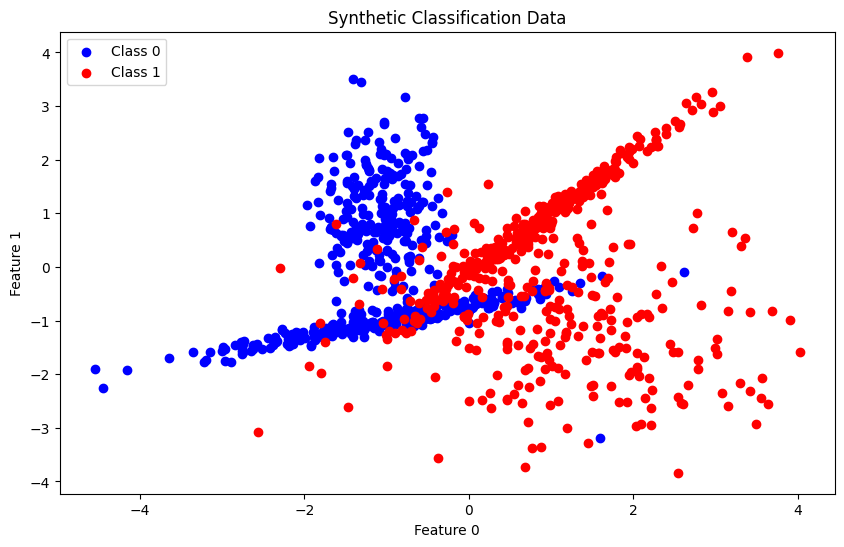

In [1]:
import numpy as np
from sklearn.datasets import make_classification

import joblib, tempfile, pathlib
from tarmaccore.cli import app
from typer.testing import CliRunner
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import warnings
import matplotlib.pyplot as plt

# Ignore convergence and feature name warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning) 

# 1. Create synthetic classification data
X, y = make_classification(n_samples=1000, n_features=2, n_classes=2, n_informative=2, n_redundant=0, n_repeated=0, random_state=42, flip_y=0.0001)

# Create scatter plot of the data points
plt.figure(figsize=(10,6))
plt.scatter(X[y==0,0], X[y==0,1], c='blue', label='Class 0')
plt.scatter(X[y==1,0], X[y==1,1], c='red', label='Class 1')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1') 
plt.title('Synthetic Classification Data')
plt.legend()
plt.show()
df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
df['target'] = y



In [2]:

# 2. Split data and save to temp files
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
test_df_a = test_df.iloc[:100]
test_df_b = test_df.iloc[100:200]

temp_path = pathlib.Path(tempfile.mkdtemp()) #Change base on where you want to save output files

# 3. Train two different classification models
X_train = train_df.drop('target', axis=1)
y_train = train_df['target']

# Create a mask for points where both features are above 1 
# (using 1 instead of 10 since the data is normalized)
high_region_mask = (X_train['feature_0'] > 0.5) & (X_train['feature_1'] > 0.5)

# Create labels - different in high region, same elsewhere
y_train_a = np.zeros(len(X_train))
y_train_b = np.zeros(len(X_train))

# Make models predict differently in high region
y_train_a[high_region_mask] = 0
y_train_b[high_region_mask] = 1

# Keep original labels where models predict the same
y_train_a[~high_region_mask] = y_train[~high_region_mask]
y_train_b[~high_region_mask] = y_train[~high_region_mask]


model_a = DecisionTreeClassifier(max_depth=3, random_state=42)
model_b = DecisionTreeClassifier(max_depth=3, random_state=42)

model_a.fit(X_train, y_train_a)  # Model A predicts 0 everywhere
model_b.fit(X_train, y_train_b)  # Model B predicts 1 in high region, 0 elsewhere

# 4. Save models
joblib.dump(model_a, temp_path/"model_a.pkl")
joblib.dump(model_b, temp_path/"model_b.pkl")

# Save features and targets
X_train_a = pd.DataFrame(X_train, columns=X_train.columns)
X_train_b = pd.DataFrame(X_train, columns=X_train.columns)
y_train_a_df = pd.DataFrame(y_train_a, columns=['target'])
y_train_b_df = pd.DataFrame(y_train_b, columns=['target'])

X_train_a.to_csv(temp_path/"Xa.csv", index=False)
y_train_a_df.to_csv(temp_path/"ya.csv", index=False)
X_train_b.to_csv(temp_path/"Xb.csv", index=False)
y_train_b_df.to_csv(temp_path/"yb.csv", index=False)



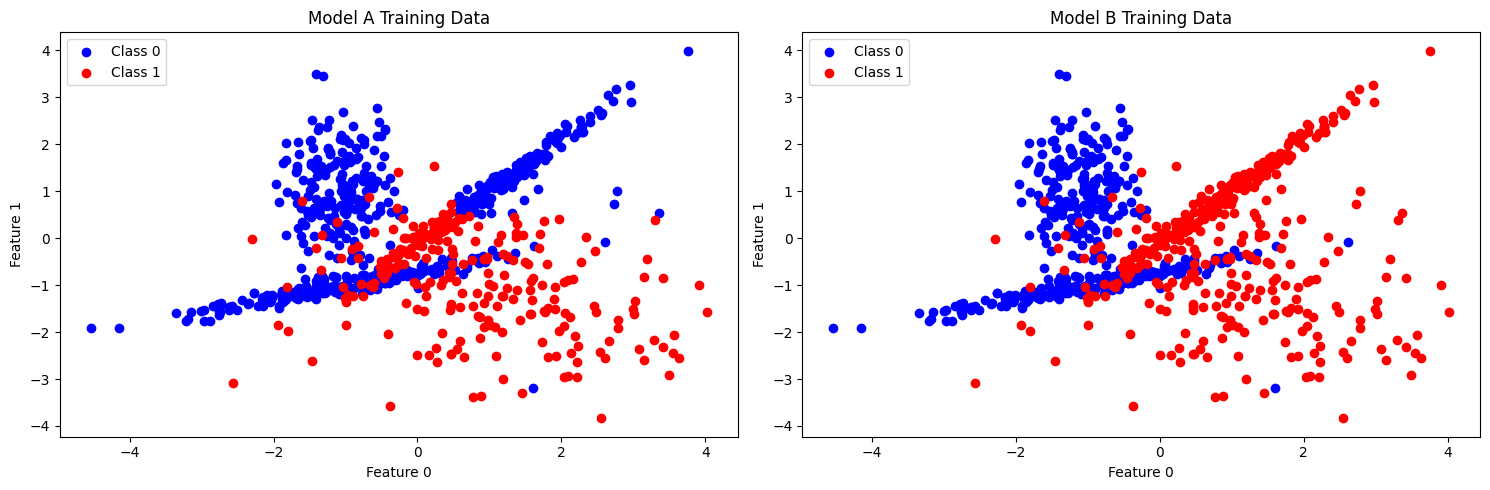

In [3]:

# Plot the training data and labels for both models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Model A's training data
ax1.scatter(X_train[y_train_a==0]['feature_0'], X_train[y_train_a==0]['feature_1'], 
           c='blue', label='Class 0')
ax1.scatter(X_train[y_train_a==1]['feature_0'], X_train[y_train_a==1]['feature_1'], 
           c='red', label='Class 1')
ax1.set_xlabel('Feature 0')
ax1.set_ylabel('Feature 1')
ax1.set_title('Model A Training Data')
ax1.legend()

# Plot Model B's training data  
ax2.scatter(X_train[y_train_b==0]['feature_0'], X_train[y_train_b==0]['feature_1'],
           c='blue', label='Class 0')
ax2.scatter(X_train[y_train_b==1]['feature_0'], X_train[y_train_b==1]['feature_1'],
           c='red', label='Class 1')
ax2.set_xlabel('Feature 0')
ax2.set_ylabel('Feature 1')
ax2.set_title('Model B Training Data')
ax2.legend()

plt.tight_layout()
plt.show()

# Vizualing differences

## Evaluating performance

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from rich.console import Console
from rich.table import Table
from rich.panel import Panel

# Load models
model_a = joblib.load(temp_path/"model_a.pkl")
model_b = joblib.load(temp_path/"model_b.pkl")

# Load datasets
Xa = pd.read_csv(temp_path/"Xa.csv")
ya = pd.read_csv(temp_path/"ya.csv").values.ravel()
Xb = pd.read_csv(temp_path/"Xb.csv") 
yb = pd.read_csv(temp_path/"yb.csv").values.ravel()

# Combine datasets
X_combined = pd.concat([Xa, Xb])
y_combined = np.concatenate([ya, yb])

# Get predictions for all combinations
pred_a_on_a = model_a.predict(Xa)
pred_a_on_b = model_a.predict(Xb)
pred_a_on_combined = model_a.predict(X_combined)

pred_b_on_a = model_b.predict(Xa)
pred_b_on_b = model_b.predict(Xb)
pred_b_on_combined = model_b.predict(X_combined)

# Calculate metrics
def get_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average='weighted'),
        "Recall": recall_score(y_true, y_pred, average='weighted'),
        "F1": f1_score(y_true, y_pred, average='weighted')
    }

metrics = {
    "Model A on Dataset A": get_metrics(ya, pred_a_on_a),
    "Model A on Dataset B": get_metrics(yb, pred_a_on_b),
    "Model A on Combined": get_metrics(y_combined, pred_a_on_combined),
    "Model B on Dataset A": get_metrics(ya, pred_b_on_a),
    "Model B on Dataset B": get_metrics(yb, pred_b_on_b),
    "Model B on Combined": get_metrics(y_combined, pred_b_on_combined)
}

# Dataset characteristics
data_summary = {
    "Dataset A": {
        "Samples": len(Xa),
        "Features": Xa.shape[1],
        "Class Distribution": np.unique(ya, return_counts=True)[1].tolist()
    },
    "Dataset B": {
        "Samples": len(Xb),
        "Features": Xb.shape[1],
        "Class Distribution": np.unique(yb, return_counts=True)[1].tolist()
    }
}

# Create performance table with improved formatting
console = Console()
table = Table(
    title="📊 Model Performance Comparison", 
    show_header=True, 
    header_style="bold blue",
    border_style="bright_blue",
    title_style="bold green"
)
table.add_column("📋 Scenario", style="cyan", width=20)
table.add_column("✓ Accuracy", justify="center", style="green")
table.add_column("📐 Precision", justify="center", style="green")
table.add_column("🎯 Recall", justify="center", style="green")
table.add_column("⭐ F1", justify="center", style="green")

for scenario, metric_dict in metrics.items():
    table.add_row(
        scenario,
        f"{metric_dict['Accuracy']:.3f}",
        f"{metric_dict['Precision']:.3f}",
        f"{metric_dict['Recall']:.3f}",
        f"{metric_dict['F1']:.3f}"
    )

# Find best and worst by F1 score
best_scenario = max(metrics.items(), key=lambda x: x[1]['F1'])
worst_scenario = min(metrics.items(), key=lambda x: x[1]['F1'])

summary = f"""
[bold cyan]📊 Performance Summary:[/bold cyan]
• 🏆 Best performance: [green]{best_scenario[0]} (F1: {best_scenario[1]['F1']:.3f})[/green]
• ⚠️ Worst performance: [red]{worst_scenario[0]} (F1: {worst_scenario[1]['F1']:.3f})[/red]
• 📏 Performance gap: [yellow]{best_scenario[1]['F1'] - worst_scenario[1]['F1']:.3f}[/yellow]

[bold cyan]📑 Dataset Characteristics:[/bold cyan]
• Dataset A: [yellow]{data_summary['Dataset A']['Samples']}[/yellow] samples, 
  [yellow]{data_summary['Dataset A']['Features']}[/yellow] features
  Class distribution: {data_summary['Dataset A']['Class Distribution']}
• Dataset B: [yellow]{data_summary['Dataset B']['Samples']}[/yellow] samples, 
  [yellow]{data_summary['Dataset B']['Features']}[/yellow] features
  Class distribution: {data_summary['Dataset B']['Class Distribution']}
"""

console.print("\n")
console.print(Panel(summary, title="📈 Analysis Summary", border_style="blue"))
console.print("\n")
console.print(table)


╭────────────────────────────────────────────── 📈 Analysis Summary ──────────────────────────────────────────────╮
│                                                                                                                 │
│ 📊 Performance Summary:                                                                                         │
│ • 🏆 Best performance: Model B on Dataset B (F1: 0.903)                                                         │
│ • ⚠️ Worst performance: Model A on Dataset B (F1: 0.685)                                                         │
│ • 📏 Performance gap: 0.219                                                                                     │
│                                                                                                                 │
│ 📑 Dataset Characteristics:                                                                                     │
│ • Dataset A: 800 samples,                                                                                       │
│   2 features                                                                                                    │
│   Class distribution: [549, 251]                                                                                │
│ • Dataset B: 800 samples,                                                                                       │
│   2 features                                                                                                    │
│   Class distribution: [404, 396]                                                                                │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

                    📊 Model Performance Comparison                     
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━┓
┃ 📋 Scenario          ┃ ✓ Accuracy ┃ 📐 Precision ┃ 🎯 Recall ┃ ⭐ F1 ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━┩
│ Model A on Dataset A │   0.873    │    0.880     │   0.873   │ 0.875 │
│ Model A on Dataset B │   0.691    │    0.706     │   0.691   │ 0.685 │
│ Model A on Combined  │   0.782    │    0.780     │   0.782   │ 0.779 │
│ Model B on Dataset A │   0.723    │    0.759     │   0.723   │ 0.731 │
│ Model B on Dataset B │   0.904    │    0.911     │   0.904   │ 0.903 │
│ Model B on Combined  │   0.813    │    0.816     │   0.813   │ 0.814 │
└──────────────────────┴────────────┴──────────────┴───────────┴───────┘

## Vizualzing differences

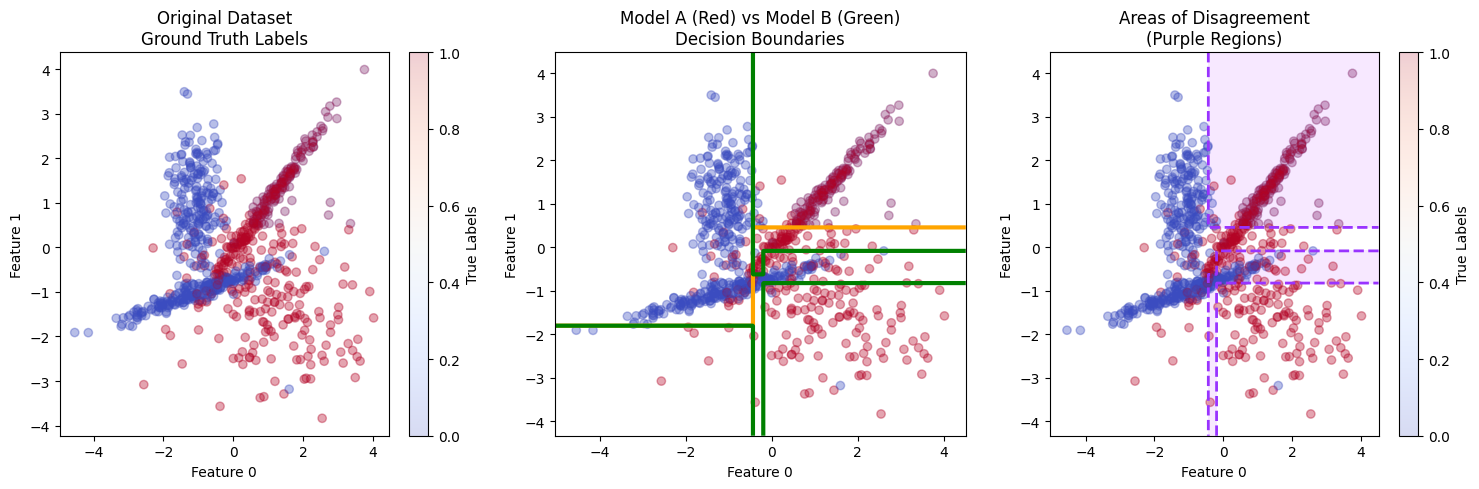

In [5]:
# Create a meshgrid for decision boundary visualization
x_min, x_max = X_combined['feature_0'].min() - 0.5, X_combined['feature_0'].max() + 0.5
y_min, y_max = X_combined['feature_1'].min() - 0.5, X_combined['feature_1'].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Create the figure and axis
plt.figure(figsize=(15, 5))

# Plot original dataset
plt.subplot(131)
plt.scatter(X_combined['feature_0'], X_combined['feature_1'],
           c=y_combined, cmap='coolwarm', alpha=0.2)  # Changed to coolwarm for cyan-red vibe
plt.colorbar(label='True Labels')
plt.title('Original Dataset\nGround Truth Labels')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')

# Create mesh points
mesh_points = np.c_[xx.ravel(), yy.ravel()]
mesh_points = np.hstack([mesh_points, np.zeros((mesh_points.shape[0], X_combined.shape[1]-2))])

# Get predictions for both models
Z_a = model_a.predict(mesh_points).reshape(xx.shape)
Z_b = model_b.predict(mesh_points).reshape(xx.shape)

# Plot decision boundaries on same plot
plt.subplot(132)
plt.contour(xx, yy, Z_a, levels=[0.5], colors=['orange'], linewidths=3)  # Model A in red
plt.contour(xx, yy, Z_b, levels=[0.5], colors=['green'], linewidths=3)  # Model B in green
plt.scatter(X_combined['feature_0'], X_combined['feature_1'], 
           c=y_combined, cmap='coolwarm', alpha=0.2)  # Changed to coolwarm
plt.title('Model A (Red) vs Model B (Green)\nDecision Boundaries')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')

# Plot where predictions differ
plt.subplot(133)
# Calculate differences in predictions
Z_diff = np.abs(Z_a - Z_b)

# Create a mask for where predictions actually differ
pred_a = Z_a > 0.5  # Convert to binary predictions
pred_b = Z_b > 0.5
disagreement_mask = pred_a != pred_b  # True where predictions differ

plt.contourf(xx, yy, disagreement_mask, alpha=0.3, colors=['white', '#E6B3FF'])  # White for agreement, light purple for disagreement
plt.contour(xx, yy, disagreement_mask, colors='#9933FF',
           linestyles='dashed', linewidths=2)
plt.scatter(X_combined['feature_0'], X_combined['feature_1'],
           c=y_combined, cmap='coolwarm', alpha=0.2)  # Changed to coolwarm
plt.colorbar(label='True Labels')
plt.title('Areas of Disagreement\n(Purple Regions)')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')

plt.tight_layout()
plt.show()


# Explaining differences [Tarmac]

In [6]:
runner = CliRunner()

## Json output

In [7]:

min_samples_leaf = 0.000001

# Test JSON output
res_json = runner.invoke(
    app,
    [
        "diff",
        str(temp_path/"model_a.pkl"),
        str(temp_path/"model_b.pkl"),
        "--sampling", "union",
        "--Xa", str(temp_path/"Xa.csv"),
        "--ya", str(temp_path/"ya.csv"),
        "--Xb", str(temp_path/"Xb.csv"),
        "--yb", str(temp_path/"yb.csv"),
        "--task", "classification",
        "-o", str(temp_path/"output.json"),
        "--min-samples-leaf", str(min_samples_leaf),
    ],
    catch_exceptions=False
)
with open(temp_path/"output.json") as f:
    json_output = f.read()

📊 Model Difference Analysis

Generated 5 rules explaining model differences:

╭──────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Rule 1: IF feature_0 > -0.428 AND feature_1 > 0.469 THEN models differ (affects 60 samples, 100.0% disagree) │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Rule 2: IF feature_1 > -0.818 AND feature_1 <= -0.074 AND feature_0 > -0.242 THEN models differ (affects 32     │
│ samples, 100.0% disagree)                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Rule 3: IF feature_0 > -0.428 AND feature_1 <= -0.818 AND feature_0 <= -0.223 THEN models differ (affects 4     │
│ samples, 100.0% disagree)                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Rule 4: IF feature_0 > -0.674 AND feature_0 <= -0.668 THEN models differ (affects 1 samples, 100.0% disagree) │
╰───────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Rule 5: IF feature_0 > -0.428 AND feature_1 > -0.818 AND feature_1 <= -0.074 AND feature_0 <= -0.419 THEN       │
│ models differ (affects 1 samples, 100.0% disagree)                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

## txt output

In [8]:

min_samples_leaf = 0.000001

# Test TXT output
res_txt = runner.invoke(
    app,
    [
        "diff",
        str(temp_path/"model_a.pkl"),
        str(temp_path/"model_b.pkl"),
        "--sampling", "union",
        "--Xa", str(temp_path/"Xa.csv"),
        "--ya", str(temp_path/"ya.csv"),
        "--Xb", str(temp_path/"Xb.csv"),
        "--yb", str(temp_path/"yb.csv"),
        "--task", "classification",
        "-o", str(temp_path/"output.txt"),
        
        "--min-samples-leaf", str(min_samples_leaf),
    ],
    catch_exceptions=False
)
with open(temp_path/"output.txt") as f:
    txt_output = f.read()

📊 Model Difference Analysis

Generated 5 rules explaining model differences:

╭──────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Rule 1: IF feature_0 > -0.428 AND feature_1 > 0.469 THEN models differ (affects 60 samples, 100.0% disagree) │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Rule 2: IF feature_1 > -0.818 AND feature_1 <= -0.074 AND feature_0 > -0.242 THEN models differ (affects 32     │
│ samples, 100.0% disagree)                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Rule 3: IF feature_0 > -0.428 AND feature_1 <= -0.818 AND feature_0 <= -0.223 THEN models differ (affects 4     │
│ samples, 100.0% disagree)                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Rule 4: IF feature_0 > -0.674 AND feature_0 <= -0.668 THEN models differ (affects 1 samples, 100.0% disagree) │
╰───────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Rule 5: IF feature_0 > -0.428 AND feature_1 > -0.818 AND feature_1 <= -0.074 AND feature_0 <= -0.419 THEN       │
│ models differ (affects 1 samples, 100.0% disagree)                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

## UI friendly txt output

In [9]:
   
min_samples_leaf = 0.000001

# Test user-friendly TXT output
res_uf = runner.invoke(
    app,
    [
        "diff",
        str(temp_path/"model_a.pkl"),
        str(temp_path/"model_b.pkl"),
        "--sampling", "union",
        "--Xa", str(temp_path/"Xa.csv"),
        "--ya", str(temp_path/"ya.csv"),
        "--Xb", str(temp_path/"Xb.csv"),
        "--yb", str(temp_path/"yb.csv"),
        "--task", "classification",
        "--uf",
        "-o", str(temp_path/"output_uf.txt"),
        
        "--min-samples-leaf", str(min_samples_leaf),
    ],
    catch_exceptions=False
)
with open(temp_path/"output_uf.txt") as f:
    uf_output = f.read()



📊 Model Difference Analysis

Generated 5 rules explaining model differences:

╭──────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Rule 1: IF feature_0 > -0.428 AND feature_1 > 0.469 THEN models differ (affects 60 samples, 100.0% disagree) │
╰──────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Rule 2: IF feature_1 > -0.818 AND feature_1 <= -0.074 AND feature_0 > -0.242 THEN models differ (affects 32     │
│ samples, 100.0% disagree)                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Rule 3: IF feature_0 > -0.428 AND feature_1 <= -0.818 AND feature_0 <= -0.223 THEN models differ (affects 4     │
│ samples, 100.0% disagree)                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Rule 4: IF feature_0 > -0.674 AND feature_0 <= -0.668 THEN models differ (affects 1 samples, 100.0% disagree) │
╰───────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Rule 5: IF feature_0 > -0.428 AND feature_1 > -0.818 AND feature_1 <= -0.074 AND feature_0 <= -0.419 THEN       │
│ models differ (affects 1 samples, 100.0% disagree)                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [10]:
print(uf_output)

📊 Analysis of Model Behavior Differences

This report identifies key patterns where the two models make different predictions.

We analyzed 320 data samples and found 5 important patterns.
Each pattern describes specific conditions where the models disagree.

Key Findings:
--------------------

Pattern #1:
What we found: When if feature_0 > -0.428 and feature_1 > 0.469 then models differ (affects 60 samples, 100.0% disagree)
This means that under these specific conditions, the models produce notably different results.

Pattern #2:
What we found: When if feature_1 > -0.818 and feature_1 <= -0.074 and feature_0 > -0.242 then models differ (affects 32 samples, 100.0% disagree)
This means that under these specific conditions, the models produce notably different results.

Pattern #3:
What we found: When if feature_0 > -0.428 and feature_1 <= -0.818 and feature_0 <= -0.223 then models differ (affects 4 samples, 100.0% disagree)
This means that under these specific conditions, the models pro